## Católica Lisbon School of Business and Economics

# Application of Explainable AI in Machine Learning models to identify the main determinants of Bitcoin price

**Sofia Morais**

In [2]:
# Load the packages
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import shap
import numpy as np
import pickle
from datetime import datetime
from scipy import stats
from sklearn import metrics
from scalecast.Forecaster import Forecaster

## 1. DATA PREPARATION

### 1.1 Creating the new dataset

In [ ]:
# Import the original dataset and save it as "original"
original = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/original/original.xlsx', header=1,index_col=0)

# Data transformation
original.index.name='Timestamp'
original = original.rename(columns={'google': 'Popularity'})
original = original.rename(columns={'n-transactions-per-block': 'Total-circulating-BTC'}) # correct the name of one variable
original = original.rename(columns={'n-transactions-per-block.1': 'n-transactions-per-block'}) # correct the name of one variable
original.drop(original.columns[-21:], axis=1, inplace=True) # Delete the columns that you will not use
original.head() # Check the first observations

In [ ]:
# Import the popularity dataset and save it
popularity = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/popularity.csv',index_col=0,header=1)

# Data transformation
popularity = popularity.rename(columns={'Bitcoin: (Worldwide)': 'popularity'})

# Delete the the rows that you will not use
for i in popularity.index:
    if i>'2021-06-13':
        popularity=popularity.drop(i)
    continue
popularity.head(300)


# Add the Bitcoin+legal keyword variable to the original dataset
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(popularity.index)-1):
        if i>=popularity.index[j] and i<popularity.index[j+1]:
            original['Popularity'][i] =popularity['popularity'][popularity.index[j]]
        continue
        
original['Popularity'].head() #check the original dataset

In [ ]:
# Import the variable gold save it
gold = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/gold.xlsx', header=4,index_col=1,sheet_name='Data')

# Create date and time with dataframe
data = pd.date_range('2014-01', periods = 104, freq ='M')

#Add to gold dataframe
gold.index=data

# Transform the data
gold.index=gold.index.strftime('%Y-%m')
gold.index.name='Timestamp'
gold= gold.drop(gold.columns[0], axis=1)
gold= gold.rename(columns={'Unnamed: 2': 'Price'})

# Delete the the rows that you will not use
for i in gold.index:
    if i<'2017-01' or i>'2021-06':
        gold=gold.drop(i)
    continue

gold.head()

In [ ]:
# Create an empty column
original['Gold']=''

# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in gold.index:
        if i==j:
            original['Gold'][i]=gold['Price'][j]
            
        continue
original['Gold'].head(32) #check the values of the first 2 months to guarantee that the values were copied

In [ ]:
# Import the binary variable of bitcoin regulation related news and save it
news_reg = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/news_regulation.xlsx', header=0,index_col=0)
news_reg.head()

# Add this variable to the original dataset
original['News Regulation'] = news_reg['news_regulation']
original.head(10) #check the original dataset

In [ ]:
## Sentiment analysis using Google Trends (GT)
# Import the variables
GT = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/GT.csv', header=1,index_col=0)

# Data transformation
GT = GT.rename(columns={'bitcoin legal: (Worldwide)': 'legal'})
GT = GT.rename(columns={'bitcoin cryptocurrency: (Worldwide)': 'cryptocurrency'})
GT = GT.rename(columns={'bitcoin scam: (Worldwide)': 'scam'})

# Delete the the rows that you will not use
for i in GT.index:
    if i>'2021-06-13':
        GT=GT.drop(i)
    continue
GT.head(300)

*"GT_legal" has a string for values than 1. Thus, they are going to be converted to 0.5 as a standard value.*

In [ ]:
#Convert string <1 in legal variable to a float
for j in range(len(original['GT_legal'])):
    if original['GT_legal'][j]=='<1':
        original['GT_legal'][j]=0.5
    continue

In [ ]:
# Add the Bitcoin+cryptocurrency keyword variable to the original dataset
original['GT_cryptocurrency']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_cryptocurrency'][i] =GT['cryptocurrency'][GT.index[j]]
        continue
original['GT_cryptocurrency'].head() #check the original dataset

In [ ]:
original['GT_scam']=''

# Add the Bitcoin+scam keyword variable to the original dataset
original['GT_scam']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_scam'][i] =GT['scam'][GT.index[j]]
        continue

original['GT_scam'].head() #check the original dataset

In [ ]:
## S&P500 index
# Import the variable
SP500 = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/SP500.csv', header=0,index_col=0)
SP500 = SP500.rename(columns={'s1': 'Value'})
SP500= SP500.drop(['conf','status1'], axis='columns')
SP500.index = pd.to_datetime(SP500.index)
SP500.index=SP500.index.strftime('%Y-%m')
SP500.head()

In [ ]:
original['SP500']=''
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in SP500.index:
        if i==j:
            original['SP500'][i]=SP500['Value'][j]
            
        continue
original['SP500'].head(32) #check the values of the first 2 months to guarantee that the values were copied

In [ ]:
# Import the variable
oil = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/oil price.xlsx', sheet_name='Data',header=4,index_col=1)
oil=oil.drop(['Unnamed: 0'],axis='columns')
oil = oil.rename(columns={'Unnamed: 2': 'Price'})

# Delete the the rows that you will not use
for i in oil.index:
    if i<'2017' or i>'2021':
        oil=oil.drop(i)
    continue
oil.head()

In [ ]:
original['Oil']=''
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y'):
    for j in oil.index:
        if i==j:
            original['Oil'][i]=oil['Price'][j]
            
        continue
original['Oil'].head(366) #check the values of the first 2 years to guarantee that the values were copied

In [ ]:
# Importing and checking the dataset of Theft news
Theft_news = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/Theft news.xlsx',index_col=0)
Theft_news.head()

# Creating an empty variable called 'Theft'
original['Theft'] = ''

# Add this variable to the original dataset
original['Theft'] = Theft_news['Theft']
original.head(10) #check the original dataset

In [ ]:
# Export the final dataset to Excel
original.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx')

### 1.2 Cleaning the data

In [4]:
# Reading the final dataset
final = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)
final.head() # check the pre-cleaned dataset

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,n-transactions-per-block,output-volume,Gold,News Regulation,GT_legal,GT_cryptocurrency,GT_scam,SP500,Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,272924.100000,1.693024e+06,1192.1,0,1.0,2,1,2275.116,52.51,1
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,272924.100000,1.693024e+06,1192.1,0,1.0,2,1,2275.116,52.51,0
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,272924.100000,1.693024e+06,1192.1,0,1.0,2,1,2275.116,52.51,0
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,276578.033333,1.797751e+06,1192.1,0,1.0,2,1,2275.116,52.51,0
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,276578.033333,1.797751e+06,1192.1,0,1.0,2,1,2275.116,52.51,0


In [5]:
# Check if there is any missing value in the dataset
check_nan = final.isnull().values.any()
print(check_nan)

False


*Thus, there is no missing data.*

## 2. DATA EXPLORATION

*Now we are able to extract the main information from the final dataset*

### 2.1 Descriptive Statistics

In [6]:
final.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
market-price,1615.0,1.130001e+04,1.279853e+04,7.809200e+02,4.394070e+03,7.941460e+03,1.061149e+04,6.355444e+04
market-cap,1615.0,1.507716e+11,1.512407e+11,6.203007e+07,6.682616e+10,1.295255e+11,1.768332e+11,1.066163e+12
trade-volume,1615.0,3.747449e+08,4.580419e+08,4.765228e+06,8.960945e+07,2.157341e+08,5.139935e+08,4.956850e+09
transaction-fees-usd,1615.0,1.378138e+06,2.378999e+06,4.154115e+04,1.765076e+05,3.943438e+05,1.248912e+06,2.128565e+07
avg-confirmation-time,1615.0,1.201923e+02,3.341697e+02,5.521109e+00,1.816567e+01,3.896196e+01,1.016503e+02,7.961568e+03
difficulty,1615.0,9.172798e+12,7.115506e+12,4.758959e+10,2.741272e+12,6.727225e+12,1.554675e+13,2.335553e+13
High,1615.0,1.165746e+04,1.319941e+04,8.264000e+02,4.653900e+03,8.158800e+03,1.089405e+04,6.437400e+04
Low,1615.0,1.093589e+04,1.238778e+04,7.395000e+02,4.318580e+03,7.714500e+03,1.025045e+04,6.234800e+04
hash-rate,1615.0,6.665707e+07,5.141388e+07,2.147763e+06,2.044515e+07,5.010417e+07,1.117642e+08,1.749392e+08
block-size,1615.0,2.151992e+05,7.085936e+04,9.729388e+04,1.566525e+05,2.093699e+05,2.739406e+05,3.458966e+05


*These table presents some information about the statistics of the variables, namely:*

*1. The difference between the mean and the median (50%) is quite significant in monetary and BTC variables. This might indicate that these variables are not normalised. Nevertheless, it is going to be checked below by plotting those distributions.*

*2. For example, average confirmation time has a maximum quite large in comparision with the median. Is it a outlier? It will be check that by plotting a histogram in the next steps.*

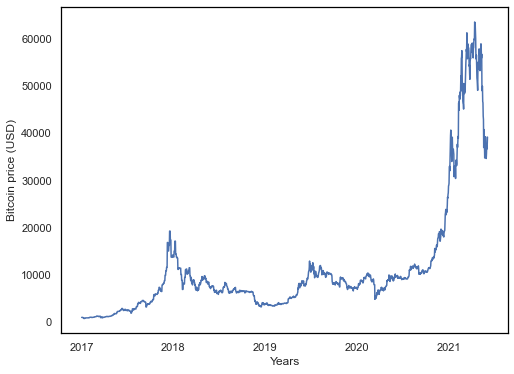

In [55]:
# Plotting the Bitcoin price between 2017 and 2021
date = final['market-price'].index
value = final['market-price']
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()

# Setting the background color of the plot to white
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')

# Setting the background color of the plot to white
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value);
plt.ylabel('Bitcoin price (USD)')
plt.xlabel('Years')
plt.grid(b=None) # Hide grid lines
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/btc_price_years.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

*Both plots show us that the BTC is the most volatile asset, comparing to Gold and S&P500.*

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


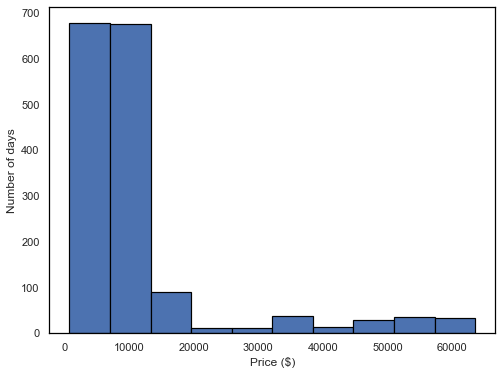

In [45]:
plt.figure(figsize=(8,6))
plt.hist(final['market-price'],edgecolor='black', linewidth=1.2)
# Setting the background color of the plot to white
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
plt.grid(b=None) # Hide grid lines

plt.ylabel('Number of days')
plt.xlabel('Price ($)')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hist_marketprice.jpg') # save this figure to use in the thesis
plt.show()

*As we can see, the BTC price is clearly skewed to the right. This means that we should apply log transformation to the variable.*

In [56]:
# Creating a new dataframe to model
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)

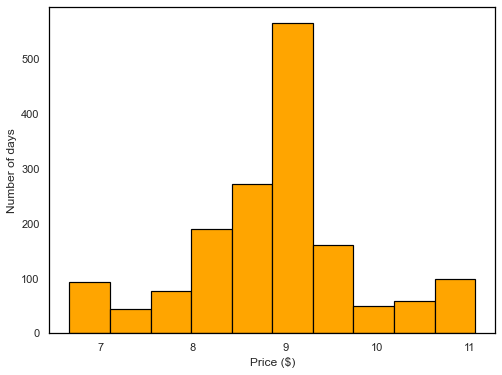

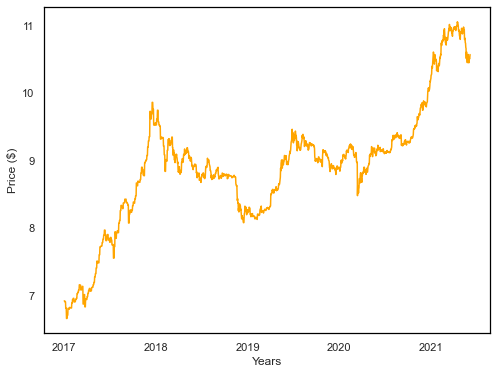

In [57]:
# Applying log transformation into price-variables, especially to make comparisions later on
model['market-price']=np.log(model['market-price'])
model['market-cap']=np.log(model['market-cap'])
model['High']=np.log(model['High'])
model['Low']=np.log(model['Low'])
model['Open']=np.log(model['Open'])
model['cost-per-transaction-percent']=np.log(model['cost-per-transaction-percent'])
model['fees-usd-per-transaction']=np.log(model['fees-usd-per-transaction'])
model['transaction-fees-usd']=np.log(model['transaction-fees-usd'])
model['Oil']=np.log(model['Oil'])
model['SP500']=np.log(model['SP500'])
model['Gold']=np.log(model['Gold'])
model['miners-revenue']=np.log(model['miners-revenue'])


# Rename the log variables
model = model.rename(columns={'market-price': 'lg_price'})
model = model.rename(columns={'market-cap': 'lg_market-cap'})
model = model.rename(columns={'High': 'lg_High'})
model = model.rename(columns={'cost-per-transaction-percent': 'lg_cost-per-transaction-percent'})
model = model.rename(columns={'Open': 'lg_Open'})
model = model.rename(columns={'Low': 'lg_Low'})
model = model.rename(columns={'fees-usd-per-transaction': 'lg_fees-usd-per-transaction'})
model = model.rename(columns={'transaction-fees-usd': 'lg_transaction-fees-usd'})
model = model.rename(columns={'Oil': 'lg_Oil'})
model = model.rename(columns={'SP500': 'lg_SP500'})
model = model.rename(columns={'Gold': 'lg_Gold'})
model = model.rename(columns={'miners-revenue': 'lg_miners-revenue'})

## Visualize the new transformation
# Histogram
plt.figure(figsize=(8,6))
# Setting the background color of the plot to white
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
plt.grid(b=None) # Hide grid lines
plt.hist(model['lg_price'],edgecolor='black', linewidth=1.2, color='orange')
plt.ylabel('Number of days')
plt.xlabel('Price ($)')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hist_logprice.jpg') # save this figure to use in the thesis
plt.show()

## Line plot
date = model['lg_price'].index
value = model['lg_price']
fig, ax = plt.subplots(figsize=(8, 6))
# Setting the background color of the plot to white
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
plt.grid(b=None) # Hide grid lines
plt.ylabel('Price ($)')
plt.xlabel('Years')
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,color='orange');
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/logprice.jpg') # save this figure to use in the thesis
plt.show()

*Now we have a Normal Distribution as intended.*

*Next, we are going to investigate the distribution of the remain explanatory variables.*

In [11]:
# Creating a temporary dataframe to plot
to_plot=pd.DataFrame(model)
to_plot=to_plot.drop(['lg_price'],axis=1)

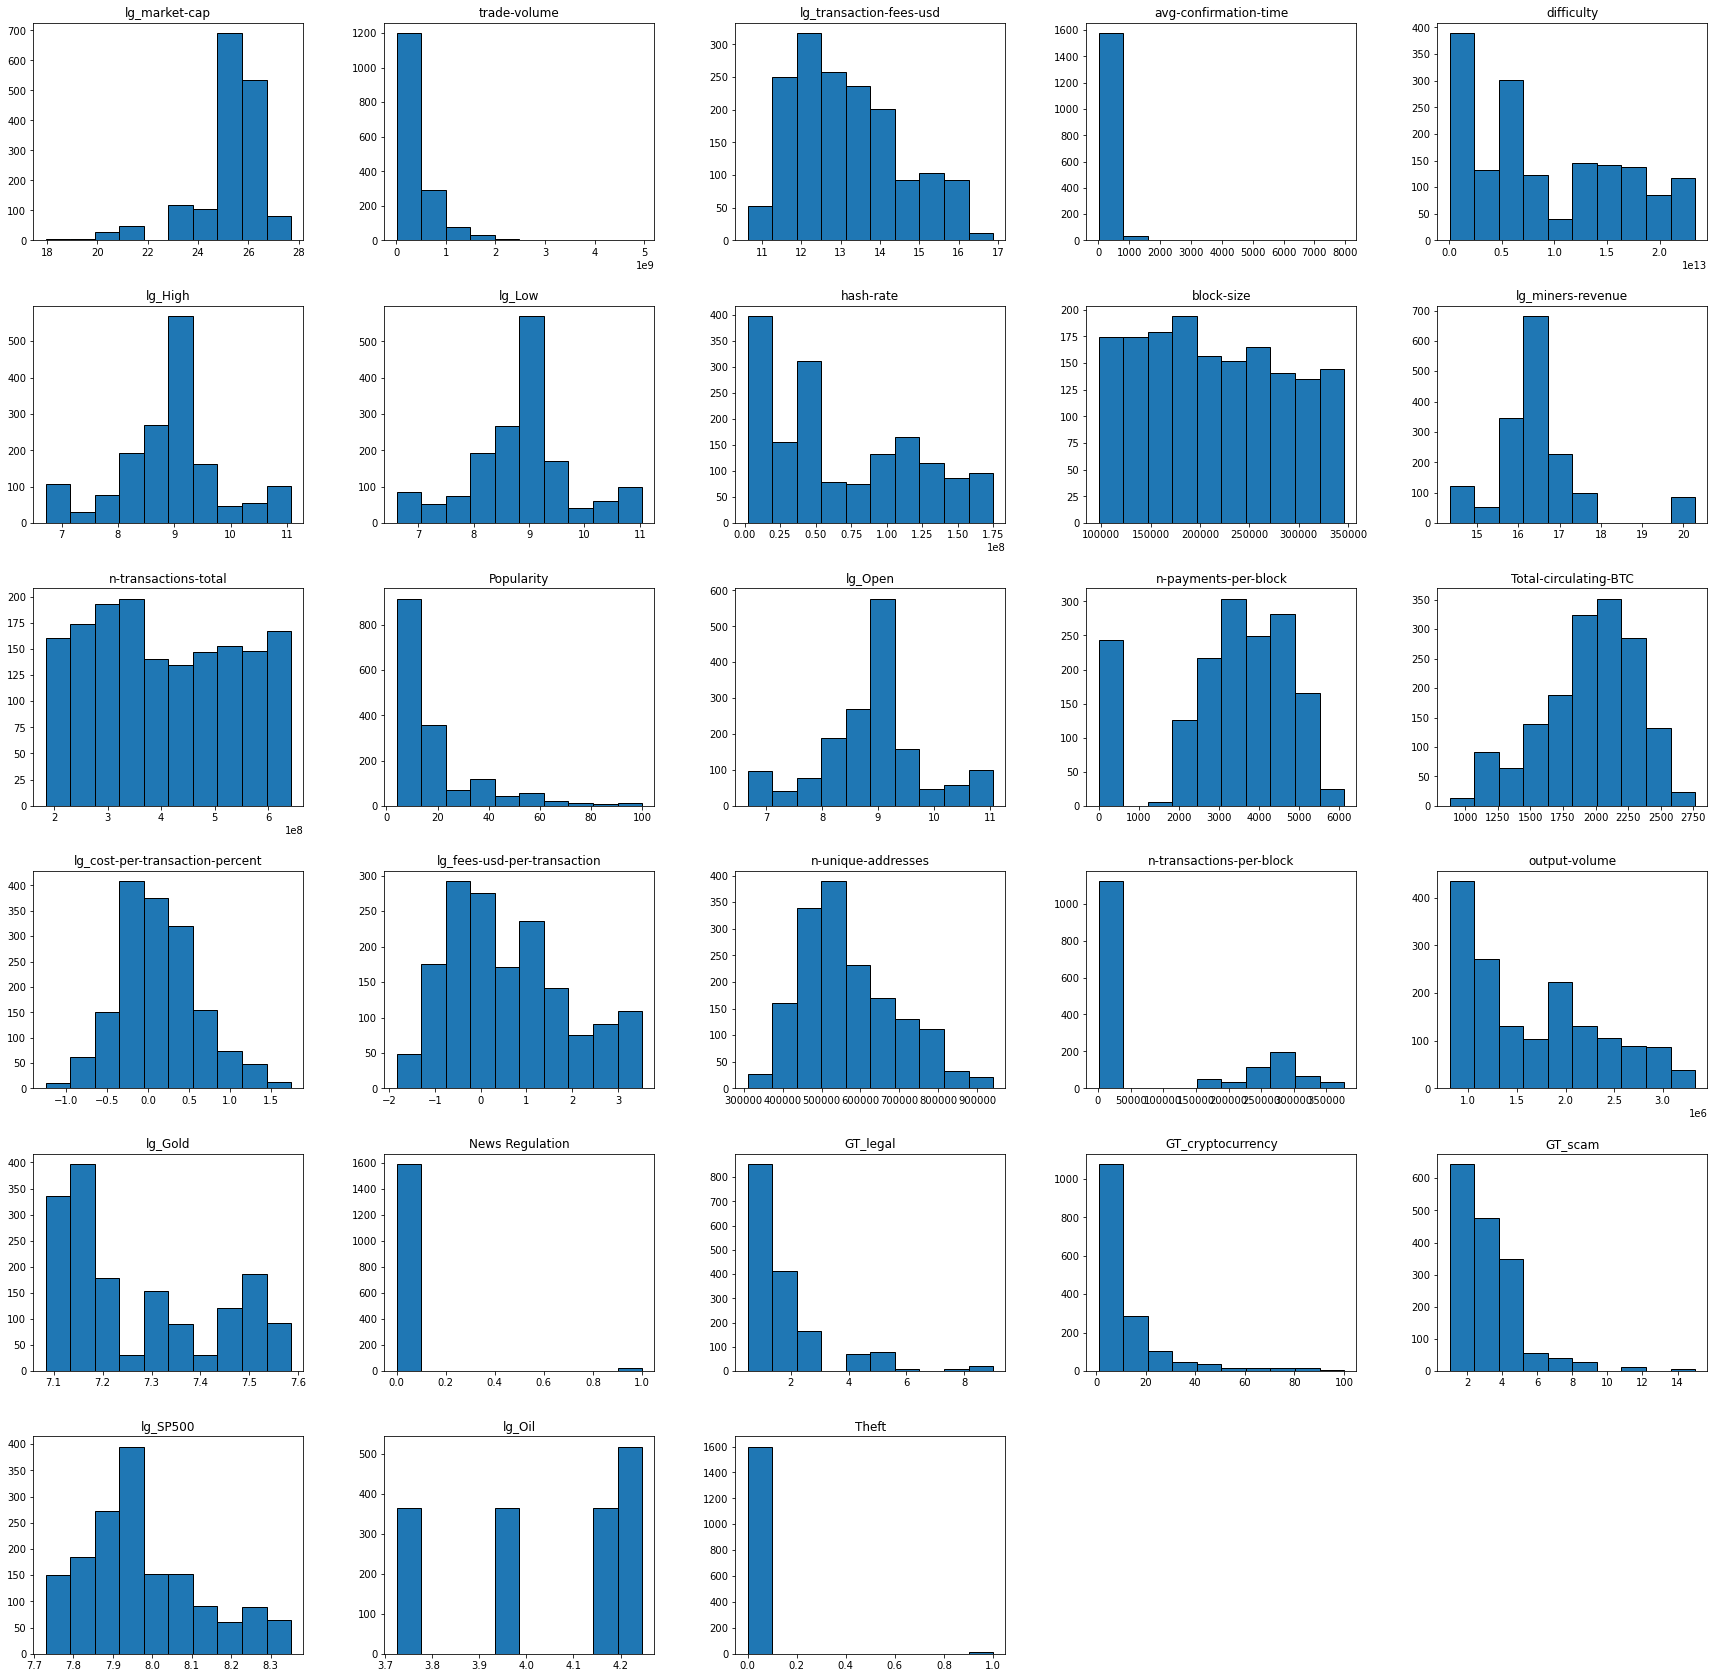

In [12]:
# Plotting the covariates distributions
to_plot.hist(figsize=(30,30),grid=False,edgecolor='black')
plt.show()

*Some of the variables are skewed. Therefore,it seems reasonable to use log transformation for all these plots. In the other situations, the log transformation does not make the desired improvements. Consequently, it will not be applied for those cases.*

In [13]:
# Log transformation
model['trade-volume']=np.log(model['trade-volume'])
model['avg-confirmation-time']=np.log(model['avg-confirmation-time'])
model['difficulty']=np.log(model['difficulty'])
model['hash-rate']=np.log(model['hash-rate'])
model['Total-circulating-BTC']=np.log(model['Total-circulating-BTC'])
model['n-unique-addresses']=np.log(model['n-unique-addresses'])
model['output-volume']=np.log(model['output-volume'])
model['difficulty']=np.log(model['Popularity'])

# Rename the variables
model = model.rename(columns={'trade-volume': 'lg_trade-volume'})
model = model.rename(columns={'avg-confirmation-time': 'lg_avg-confirmation-time'})
model = model.rename(columns={'difficulty': 'lg_difficulty'})
model = model.rename(columns={'hash-rate': 'lg_hash-rate'})
model = model.rename(columns={'Total-circulating-BTC': 'lg_circulatingBTC'})
model = model.rename(columns={'n-unique-adresses': 'lg_n-unique-adresses'})
model = model.rename(columns={'trade-volume': 'lg_trade-volume'})
model = model.rename(columns={'output-volume': 'lg_output-volume'})
model = model.rename(columns={'Popularity': 'lg_Popularity'})

In [14]:
# Export the dataset to Excelthat will be used to modelling
model.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx')

Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).


In [15]:
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

In [16]:
external=model[['lg_Popularity','lg_Gold','lg_Oil','lg_SP500','GT_legal','GT_cryptocurrency','GT_scam','News Regulation','Theft']]

In [17]:
external.head(3)

,lg_Popularity,lg_Gold,lg_Oil,lg_SP500,GT_legal,GT_cryptocurrency,GT_scam,News Regulation,Theft
Timestamp,,,,,,,,,
2017-01-01,7,7.083472,3.961004,7.729786,1.0,2,1,0,1
2017-01-02,7,7.083472,3.961004,7.729786,1.0,2,1,0,0
2017-01-03,7,7.083472,3.961004,7.729786,1.0,2,1,0,0


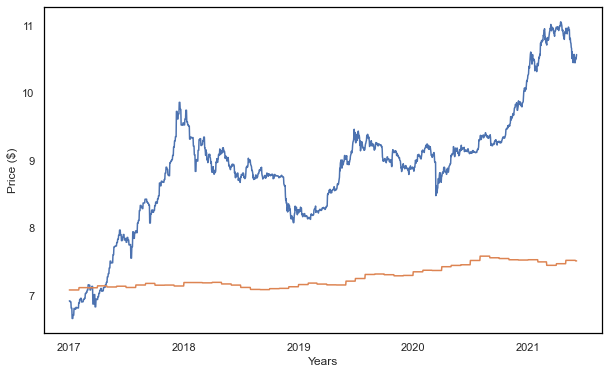

In [60]:
# Plotting the the log of Bitcoin price vs the log of Gold price between 2017 and 2021
date = model['lg_price'].index
value = model['lg_price']
value1 = model['lg_Gold']
value2 = model['lg_SP500']
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
plt.grid(b=None) # Hide grid lines
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,value1)
plt.xlabel('Years')
plt.ylabel('Price ($)')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/BTCvsGold.jpg') # save this figure to use in the thesis

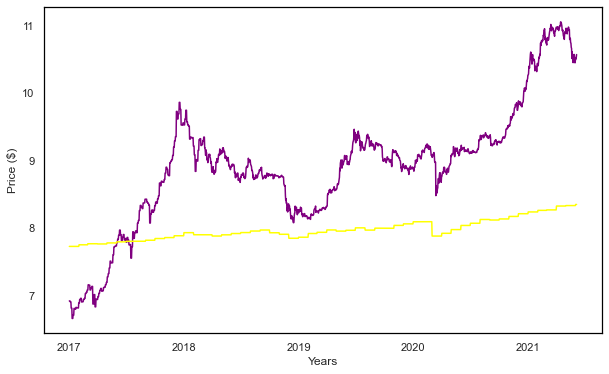

In [61]:
# Plotting the log of Bitcoin price vs the log of SP500 price between 2017 and 2021
fig, ax = plt.subplots(figsize=(10, 6))
year_locator = mdates.YearLocator()
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
plt.grid(b=None) # Hide grid lines
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,color='purple')
ax.plot(date, value2,color='yellow')
plt.xlabel('Years')
plt.ylabel('Price ($)')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/BTCvsSP500.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

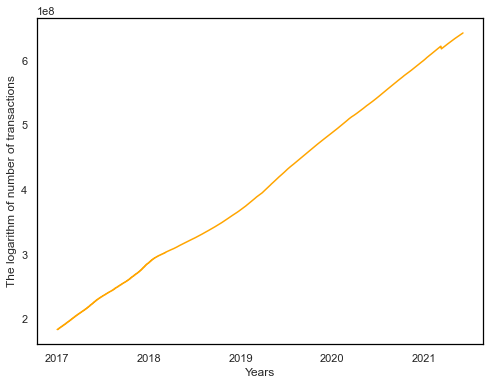

In [65]:
# PLot number of transactions of BTC over time
date = model['n-transactions-total'].index
value = model['n-transactions-total']
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
plt.grid(b=None) # Hide grid lines
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,color='orange');
plt.xlabel('Years')
plt.ylabel('The logarithm of number of transactions')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/n_transactions.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

*This plot shows that there is clearly a peak in 2020 on the number of BTC transactions and since then the variable is still decreasing.*

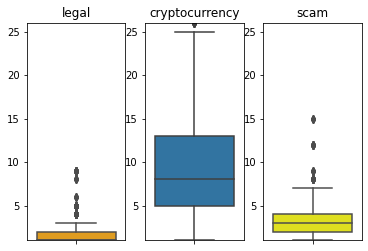

In [21]:
# Finding which keyword associated with Bitcoin that is more frequent in Google Trends
# Bitcoin+legal - POSITIVE SENTIMENT
plt.subplot(1,3,1)
sns.boxplot(y='GT_legal',data=model,color='orange')
plt.ylim(1, 26)
plt.ylabel('')
plt.title('legal')

# Bitcoin+cryptocurrency - NEUTRAL SENTIMENT
plt.subplot(1,3,2)
sns.boxplot(y='GT_cryptocurrency',data=model)
plt.ylim(1, 26)
plt.ylabel('')
plt.title('cryptocurrency')

# Bitcoin+scam - NEGATIVE SENTIMENT
plt.subplot(1,3,3)
sns.boxplot(y='GT_scam',data=model, color='yellow')
plt.ylim(1, 26)
plt.ylabel('')
plt.title('scam')

# Save this figure to use in the thesis
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/GT_boxplots.jpg') 

*It seems that, on average, the neutral sentiment regarding Bitcoin is the more predominat, comparing to the positive sentiment and the negative sentiment expressed through Google searches.*

In [22]:
model= pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

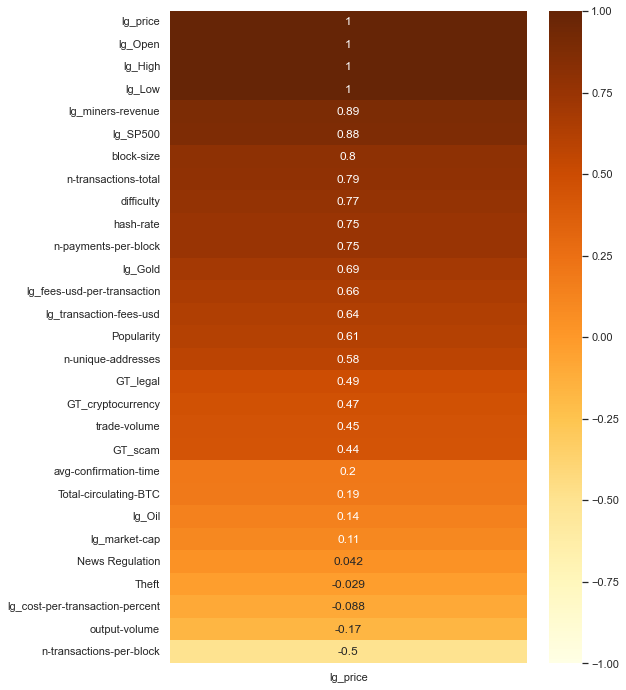

In [66]:
model.corr()[['lg_price']].sort_values(by='lg_price', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(model.corr()[['lg_price']].sort_values(by='lg_price', ascending=False), vmin=-1, vmax=1, annot=True, cmap="YlOrBr")
# save this figure to use in the thesis
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/corr_lg_price_heatmap.jpeg') 

*Most important conclusions obtained from this correlations heatmap:*

*1. The log of SP500 presents the highest correlation in the log of BTC price and it is not a transactions-based variable.*

*2. Although "legal" is not the most frequent Google Trend keyword, comparing to the other two, it is the most correlated one with BTC price. Note that this keyword represents a positive sentiment regarding Bitcoin.*

*3. An interesting fact is that when consumers' confidence index increases, which reflects a positive sentiment about the general economic situation, unemployment and capability of savings, the log of BTC price decreases. In this case, will they demand substitute assets of BTC?*

*4. There are transaction-based variables that are not highly correlated with the log of BTC price, as it had been expected, namely the log of market capitalisation.*

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


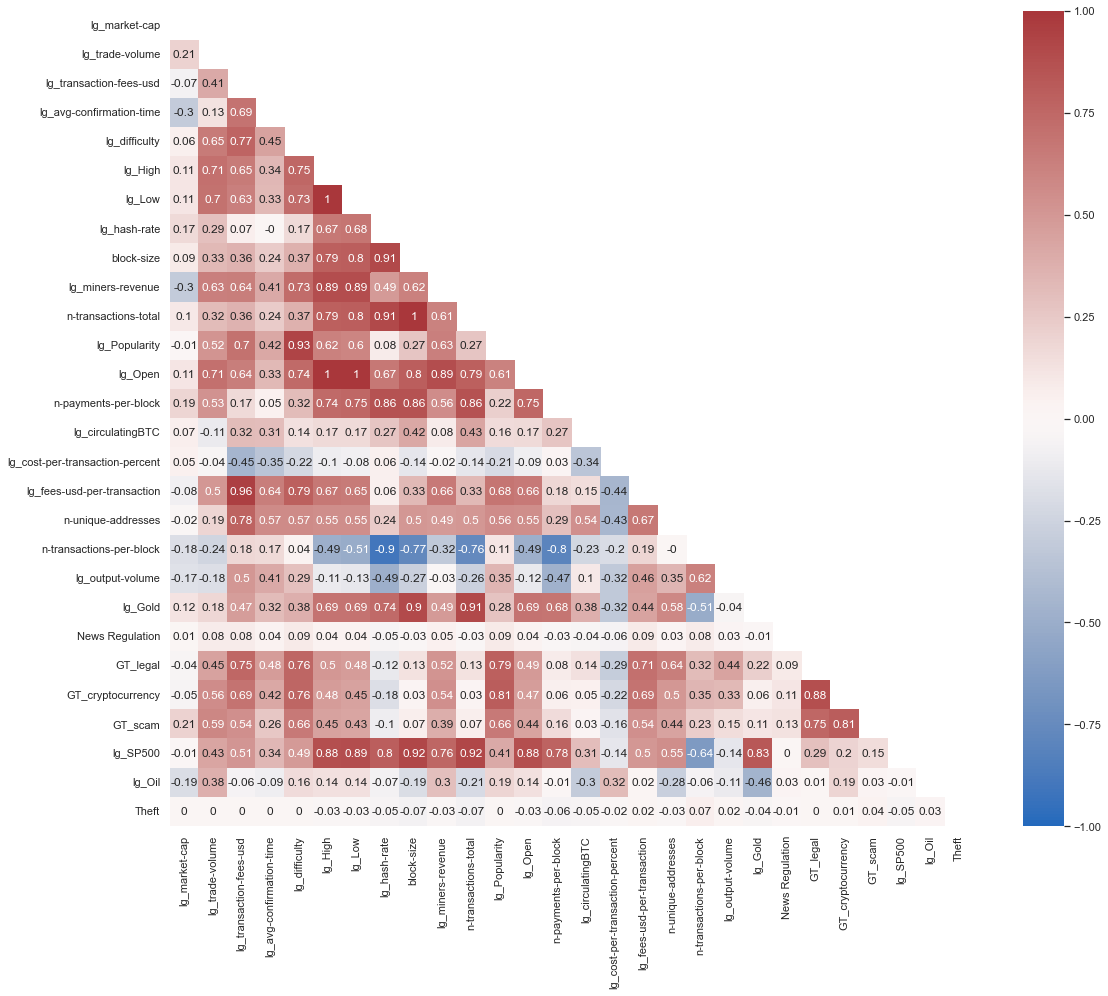

In [68]:
# Checking the correlation among variables
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)
temporary=model.iloc[:,1:]
matrix = temporary.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.set(rc = {'figure.figsize':(18,15)})
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)

# Setting the background color of the plot
ax = plt.axes()
ax.set_facecolor("white")

plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/corr_all_heatmap.png') 
plt.show()

*The correlation matrix represented in the heatmap indicates perfect correlation between 'n-transactions-total' and 'block-size'. Regarding the other perfect correlations, one of the variables was already expected to be removed in GLS model due to other issues.*

*This information will be taken into account when formulating the GLS model.*

### 2.2 - Time series

In [78]:
f = Forecaster(y=model['lg_price'],
                   current_dates=model.index)
f

Forecaster(
    DateStartActuals=2017-01-01T00:00:00.000000000
    DateEndActuals=2021-06-04T00:00:00.000000000
    Freq=None
    N_actuals=1615
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

#### Stationarity analysis

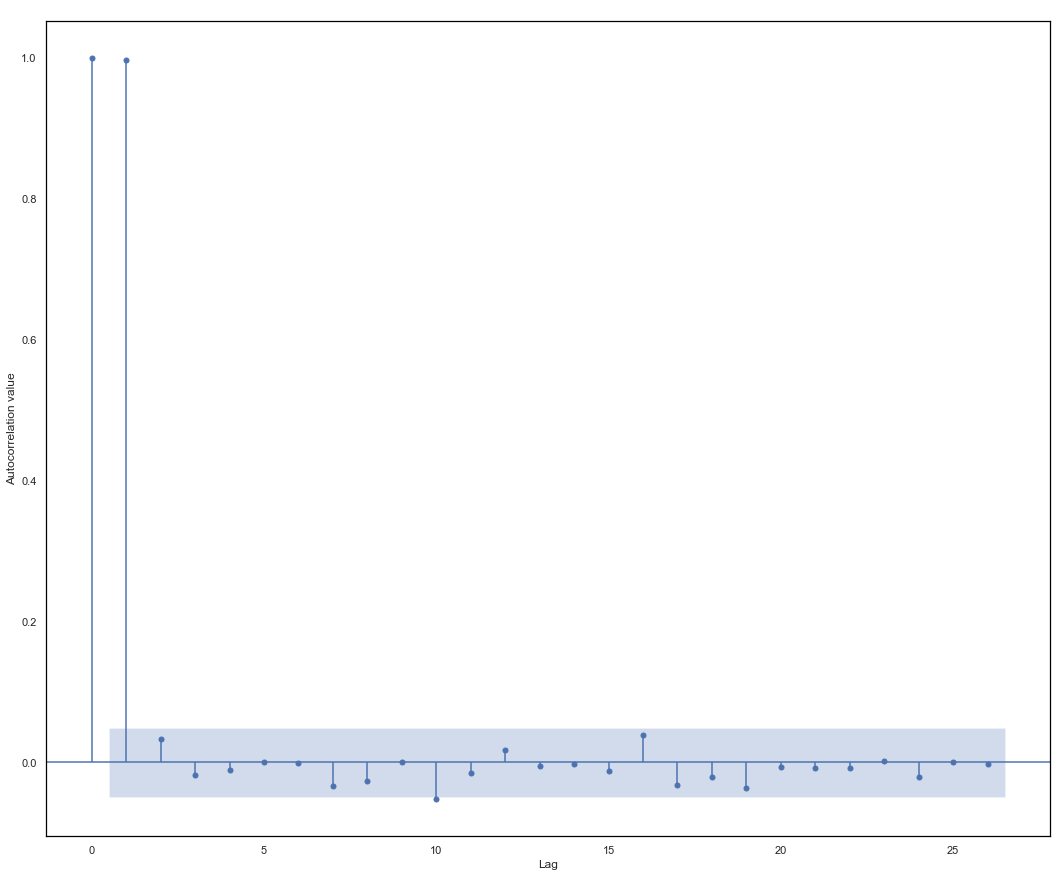

In [84]:
f.plot_pacf(lags=26)
plt.title(' ')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation value')
plt.grid(b=None) # Hide grid lines

# Setting the background color of the plot to white
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')

plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/partial_autocorr.jpeg')
plt.show()

*It was decomposed this time series by viewing the PACF (Partial Auto Correlation Function) plot, which measures how much the y variable (lg_price) is correlated to past values of itself and how far back a statistically significant correlation exists. The PACF plot is different from the ACF plot in that PACF controls for correlation between past terms. It is good to view both, but only PACF will be displayed here.*

*This plot indicates a statistically significant correlation may exist up to two days in the data. That will be good information to use when modeling.*

In [85]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat,pval)

-1.3456970510343045 0.6080153946478748


*In this case, the trend is clearly non-stationary as it is increasing upward year-after-year. In addition, the results of the Augmented Dickey-Fuller (ACF) test give statistical justification to what our eyes see. Since the p-value is not less than 0.05, we must assume the series is non-stationary.*

#### Normality analysis

In [86]:
from scipy import stats
# Reading the dataset without the timestamp as the index
dataset = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx')
SP500_price = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',usecols=['Timestamp', 'lg_SP500'])
lg_price = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',usecols=['Timestamp', 'lg_price'])
X = sm.add_constant(SP500_price['lg_SP500'])
ols = sm.OLS(lg_price['lg_price'],X)
results = ols.fit()
residual = lg_price['lg_price']-results.params[0] - results.params[1]*SP500_price['lg_SP500']
print('p value of Jarque-Bera test is: ', stats.jarque_bera(residual)[1])
print('p value of Shapiro-Wilk test is: ', stats.shapiro(residual)[1])
print('p value of Kolmogorov-Smirnov test is: ', stats.kstest(residual, 'norm')[1])

p value of Jarque-Bera test is:  0.00015304940158544778
p value of Shapiro-Wilk test is:  1.2971531404559755e-08
p value of Kolmogorov-Smirnov test is:  2.8294370224103945e-64


*If a significance level of 0.05 is chosen, then all the three normality tests indicate the residual term does not follow normal distribution. Therefore, the estimators will be biased.*

#### Homogeneity analysis

In [88]:
import statsmodels.stats.api as sms

print('p value of Goldfeld–Quandt test is: ', sms.het_goldfeldquandt(results.resid, results.model.exog)[1])
print('p value of Breusch–Pagan test is: ', sms.het_breuschpagan(results.resid, results.model.exog)[1])
print('p value of White test is: ', sms.het_white(results.resid, results.model.exog)[1])

p value of Goldfeld–Quandt test is:  0.9999999999999999
p value of Breusch–Pagan test is:  3.3121327449488776e-34
p value of White test is:  1.0374278316295294e-43


*If a significance level of 0.05 is chosen, then the last two normality tests indicate the residual term does not follow normal distribution. Therefore, the estimator will be inefficient.* 